# Text Mining

COURTENAY Rebecca 

RECAPPE Thomas

In [1]:
import os
import re
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# Partie 1 : Construction d'un corpus d'apprentissage

## Construction d'un dictionnaire 

    Pour commencer, nous avons voulu compléter le dictionnaire fourni avec deux méthodes : 
###  Geonames : https://www.geonames.org/ 
Ici, nous avons récupérer un fichier texte contenant une liste, très compléte de plusieurs lieu. 

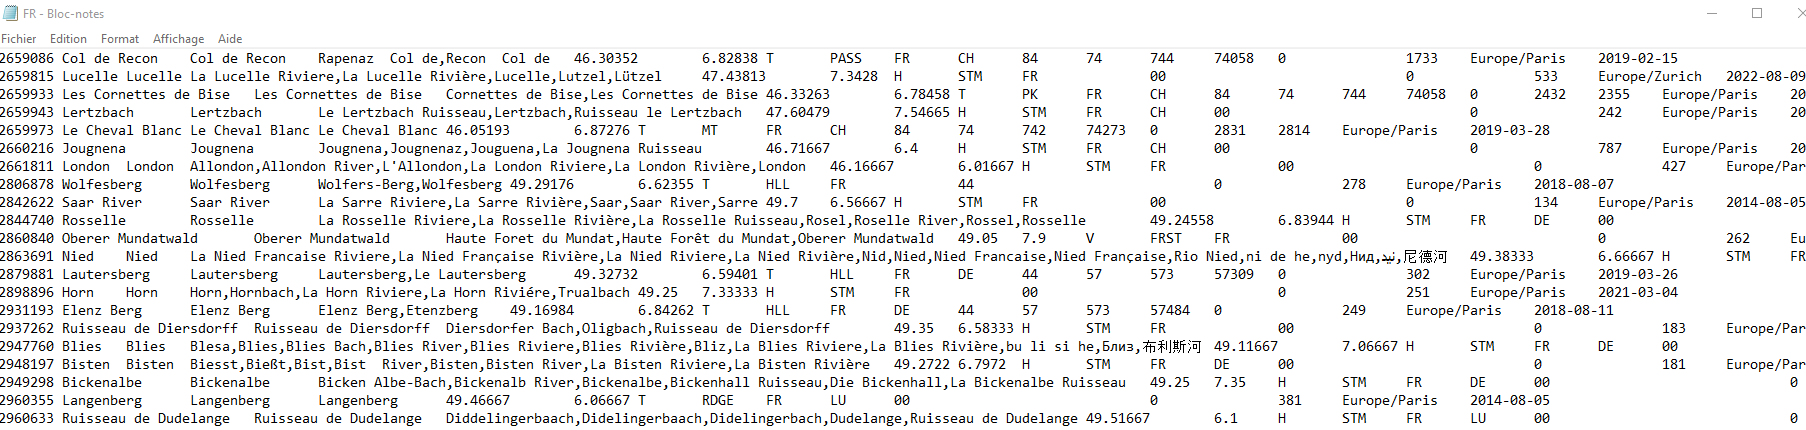

De ce fait, on a retravaillé ce fichier pour ne récupérer que les noms de lieu et non les informations autour à l'aide d'excel. 
Dans le fichier texte, une "colonne" indique des lettres qui elles indiquent les 'features classes' (cf. https://download.geonames.org/export/dump/readme.txt) c'est-à-dire si le lieu est une route, lac, parc, etc. Ainsi, dans la colonne B de excel, nous extractons ces lettres puis dans la colonne D on ajoute cette charactèristique + le toponyme. Ainsi, on peut rajouter notre nom de lieu (colonne A) avec, ensuite, son type pour obtenir un nouveau dictionnaire (colonne F). 

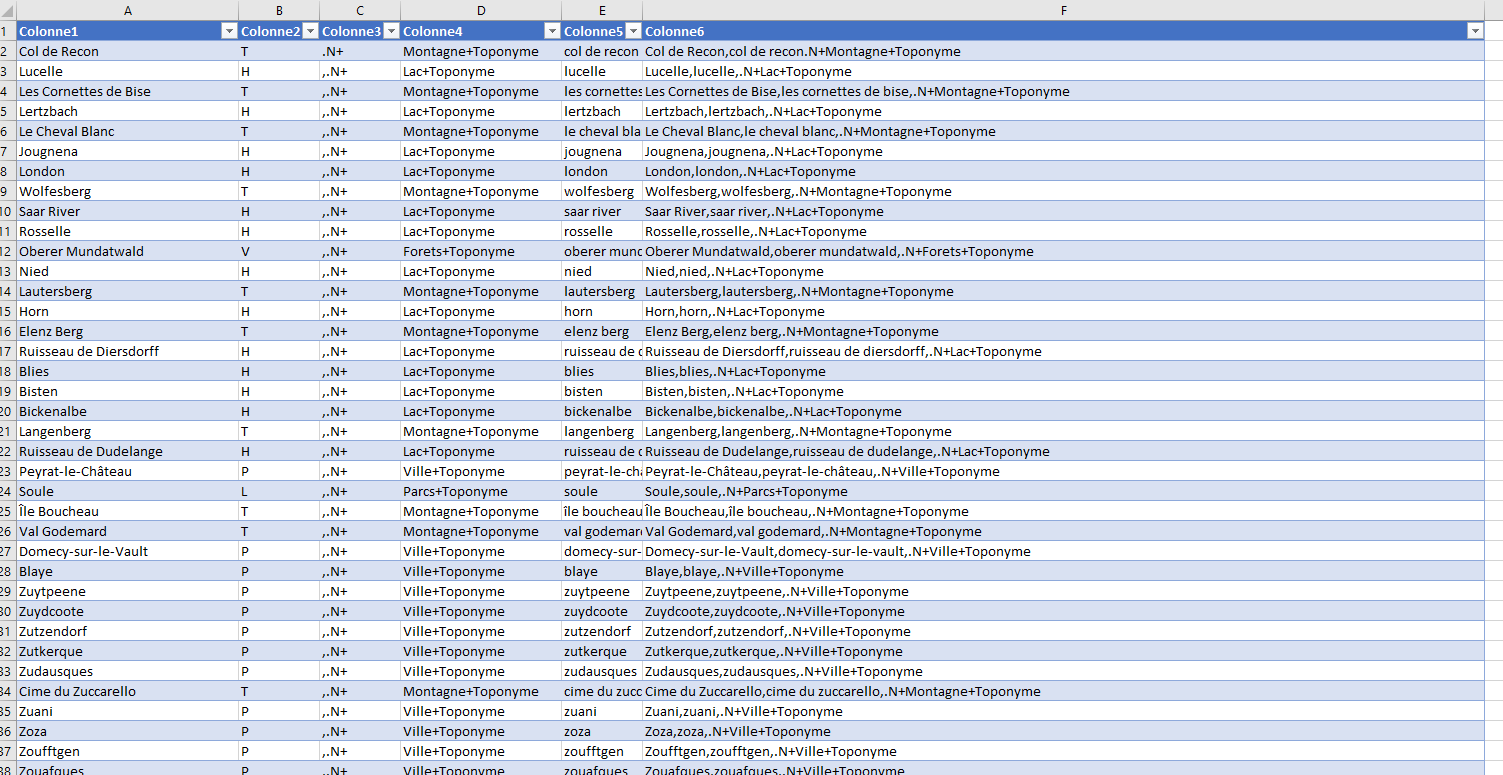

### Avec une expréssion régulière : 

Pour cela, nous avons analysé l'ensemble des textes sous python et à l'aide d'une expréssion régulière et de plusieurs conditions, nous avons pu compléter notre dictionnaire. 

En effet, nous avons créer une fonction (find_toponym) afin de sortir les toponymes grâce à une expression régulière : 

(?<=[^\w\n])\b([A-Z][a-z]+ [A-Z][a-z]+|[A-Z][a-z]+)\b

Ici, nous avons : 

- (?<=[^\w\n]): un groupe de lookbehind positif. Il permet de s'assurer que le mot qui suit n'est pas précédé par un caractère alphanumérique (\w) ou un saut de ligne (\n).

- \b:  un ancre de mot, qui permet de s'assurer que le mot cherché commence et se termine par une frontière de mot. Cest-à-dire qu'il permet de s'assurer que le mot ne fait pas partie d'un mot plus long.

- ([A-Z][a-z]+ [A-Z][a-z]+|[A-Z][a-z]+): le motif que nous cherchons à trouver. Il est composé de deux parties séparées par un pipeline "|" :

    - [A-Z][a-z]+ [A-Z][a-z]+: recherche une première lettre en majuscule [A-Z] suivie d'une ou plusieurs lettres en minuscule [a-z]+, un espace, une autre première lettre en majuscule [A-Z] et une ou plusieurs lettres en minuscule [a-z]+ (exemple : 'Saint Denis')

    - [A-Z][a-z]+: c'est la même expression régulière que précédemment, mais sans l'espace et la deuxième partie pour le deuxième nom propre (exemple : 'Quimper')
    
Ainsi, cette expression régulière recherche des noms propres dans un texte.

Mais voyant qu'elle ne prend pas en compte tous les critères que nous pouvons trouver dans ces textes, on a rajouté une condition "if" afin que ça ne prenne pas : 
- ". " : cela vérifie que le mot n'est pas précédé d'un point suivi d'un espace, ce qui pourrait indiquer la fin d'une phrase et donc un mauvais découpage.
- "[\n.] " : cela vérifie que le mot n'est pas précédé d'un point ou d'un saut de ligne suivi d'un espace, ce qui pourrait également indiquer la fin d'une phrase et donc un mauvais découpage
- "- " : cela vérifie que le mot n'est pas précédé d'un tiret suivi d'un espace, ce qui pourrait indiquer un trait d'union plutôt qu'un nom propre.
- les mots de la liste : cela vérifie que le mot n'est pas dans une liste d'exceptions ["De", "Du", "D'", "Les", "Le", "La", "L'"]

Si toutes ces conditions sont remplies, le mot est considéré comme un nom propre valide et est ajouté à la liste mots_filtres. Sinon, le mot est ignoré.

En somme, cette instruction if permet de filtrer les noms propres trouvés par l'expression régulière précédente en ne gardant que ceux qui ont un contexte approprié et qui ne sont pas des exceptions.

In [2]:
def find_toponym():
    fl = []

    # nom du dossier contenant tous les fichiers
    dir_path = './Corpus_TextMinig_22_23/'

    # fichier de sorti
    output_file = open('toponyms.txt', 'w')

    # for pour  tous les fichiers dans le dossier
    for file_name in os.listdir(dir_path):
        # lire les fichiers du dossier
        with open(os.path.join(dir_path, file_name), 'r') as file:
            text = file.read()

        #     regex = r"(?<=[^\w\n])\b([A-Z][a-z]+ [A-Z][a-z]+|[A-Z][a-z]+)\b"
        #     mots = re.findall(r'(\b([A-Z][a-z]+ [A-Z][a-z]+|[A-Z][a-z]+|[A-Z][a-z]+)\b)', text)

        regex = r"(?<=[^\w\n])\b([A-Z][a-z]+ [A-Z][a-z]+|[A-Z][a-z]+)\b"

        mots = re.findall(regex, text)
        mots_filtres = []

        exception = ["De", "Du", "D'", "Les", "Le", "La", "L'"]

        for mot in mots:
            if ". " not in text[text.index(mot) - 2:text.index(mot)] and \
                    "[\n.] " not in text[text.index(mot) - 2:text.index(mot)] and \
                    "- " not in text[text.index(mot) - 2:text.index(mot)] and \
                    mot not in exception:
                mots_filtres.append(mot)
        fl.append([file_name, mots_filtres])

        # ecrire les toponymes dans le fichier de sorti
        for toponym in mots_filtres:
            output_file.write(toponym + ',.N+PR+Toponyme:fs\n')

    output_file.close()

    return fl

In [36]:
top = find_toponym()
top[:1]

[['10_nettoye.txt',
  ['Saint Albin',
   'Seznec',
   'Quimper',
   'Plogonnec',
   'Saint Denis',
   'Kerven',
   'Saint Albin',
   'Keringar',
   'Saint Albin',
   'Pont',
   'Ty Nevez',
   'Kerolivier',
   'Cascade',
   'Trogour',
   'Trogour Huella',
   'Quimper Plogonnec']]]

## Repérer expressions norminales associées aux toponymes

Une fois le dictionnaire complété, il a fallu l’appliquer à chacun des textes du corpus de textes. Afin de faciliter cette partie, nous avons en amont concaténer l’ensemble des textes dans un seul fichier texte. En effet, nous avons copié chaque texte dans un seul fichier : 'Tout_mes_textes.txt'.

In [4]:
dir_path = './Corpus_TextMinig_22_23/'
output_file = open('Tout_mes_textes.txt', 'w')

    # regarde dans le dir_path 
for file_name in os.listdir(dir_path):
    # lis les texte du fichier 
    with open(os.path.join(dir_path, file_name), 'r', encoding="utf-8") as f:
        for line in f:
            output_file.write(line)
            
output_file.close()

Puis nous pouvons appliquer une seule fois notre dictionnaire sur ce texte sous Unitex.

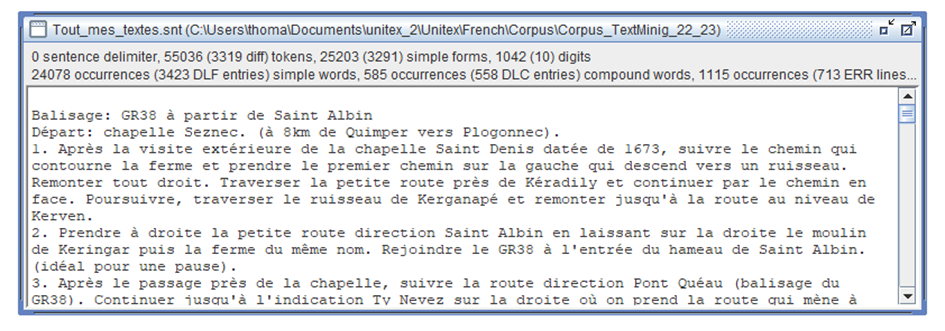

Ensuite, nous appliquons le dictionnaire : 

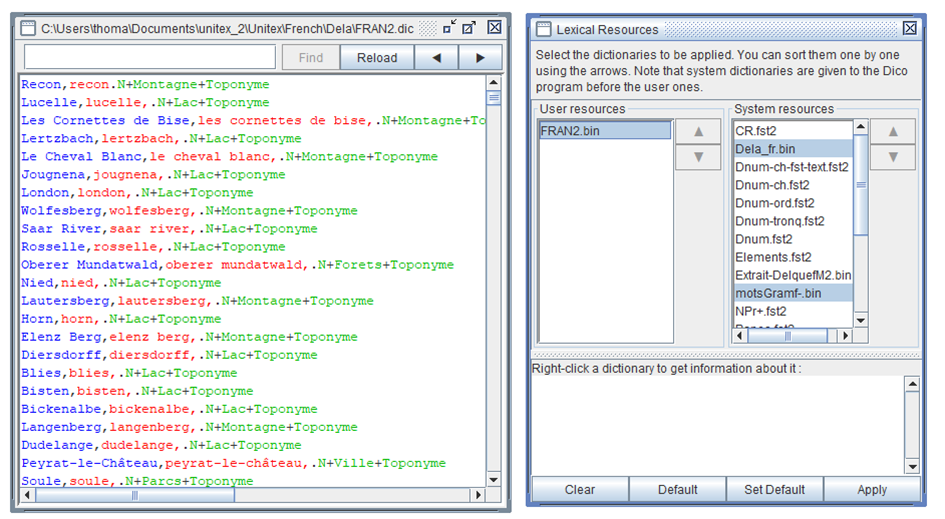

Afin de traiter le texte, nous utilisons deux graphes principaux dans la cascade avec la configuration « MERGE » : 

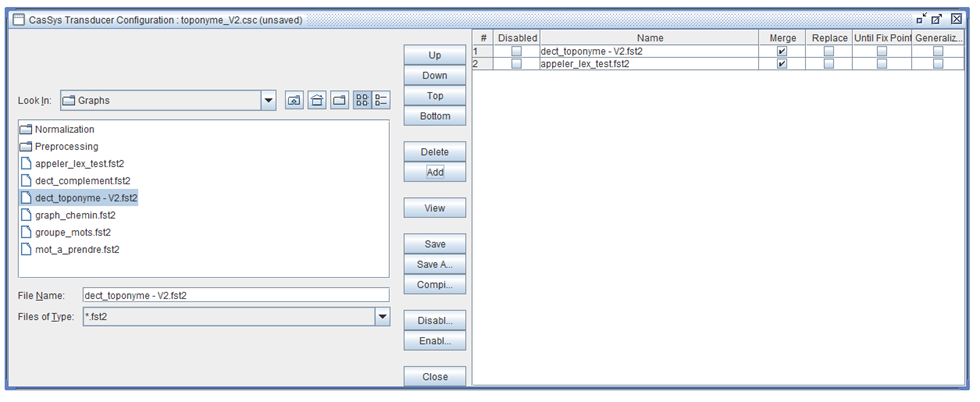
 
- dect_toponyme-V2, l’objectif de ce graphe est de détecter les toponymes dans le texte, et de d’annoter par 'target' les mots liés à celui-ci.
- appeler_lex_test, l’objectif de ce graphe est de prendre les trois mots avant et après des mots avec l’annotation 'target'. Et pour chacun de ces mots sélectionnés, vérifier si c’est un toponyme ou non. 

Voici un exemple de sortie de notre cascade :   



Le toponyme de cette phrase est “chemin”, le mot lié qui le précède est “sur” ce sera notre 'target'. Les trois tokens avant de notre 'target' sont pris en compte, si un d’eux correspond à un toponyme, il sera annoté 'topo1','topo2', 'topo3' selon leur emplacement. Sinon il seront annotées 'mot1', 'mot2', 'mot3'. De même pour les trois tokens après notre 'target'.

Une fois que nous avons appliqué la cascade sur le texte “Tout_les_textes.txt”, Unitex nous génère entre autres le fichier  “Tout_les_textes_csc.txt”. Ce fichier écrit sous forme HTML, contient les annotations de 'mot' 'topo' et 'target' que nous allons utiliser dans la partie python.

### Détails des graphes utilisés 

Voici la hiérarchie des graphes et sous-graphes utilisés dans Unitex : 
- Dect_toponyme-V2
    - dect_complement
        - graph_chemin
- appeler_lex_test
    - groupe_mots
        - mot_a_prendre

Commençons par le premier par le sous-graphe graph_chemin : 

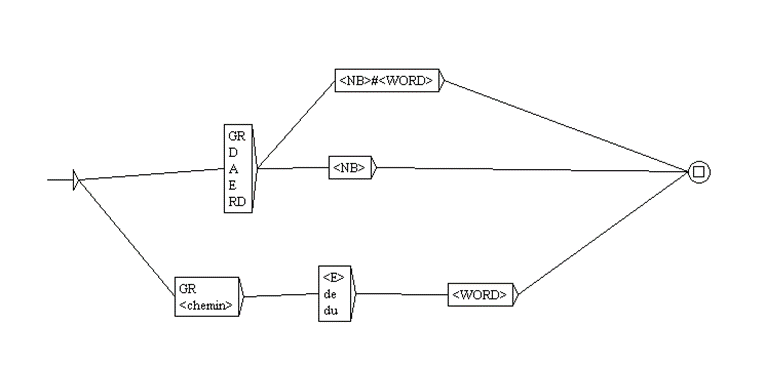

L’objectif de celui-ci est de reconnaître les chemins et nom de route comme la “D56”, ou le “chemin du ruisseau” par exemple.

Ce sous graphe est utilisé dans le graphe dect_complement.

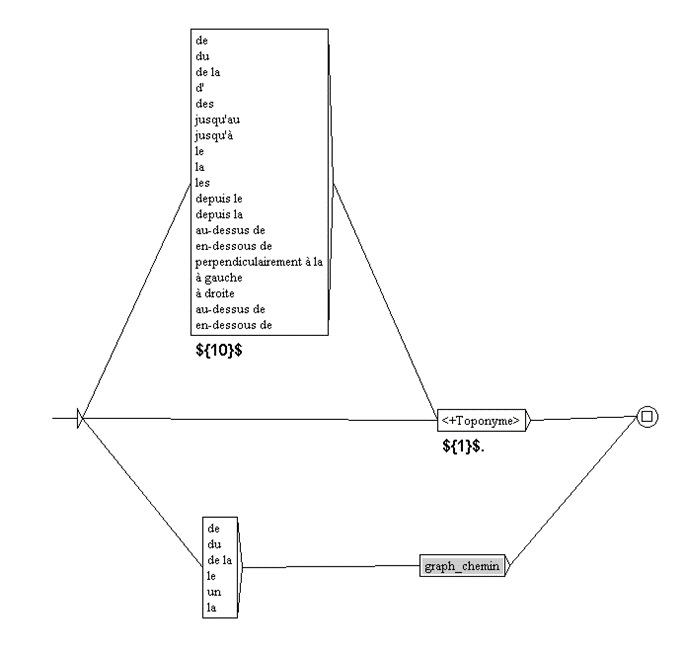

Ce graphe est utilisé pour reconnaître d’abord, les Tokens correspondant aux toponymes de notre dictionnaire précédés d’articles définis et indéfinis ou des prépositions. Sinon les tokens correspondant à un toponyme, mais sans articles ou des prépositions. Il nous permet également de détecter les chemins précédés d’articles.

Ce graphe est utilisé dans le graphique principal : dect_toponyme-V2. 

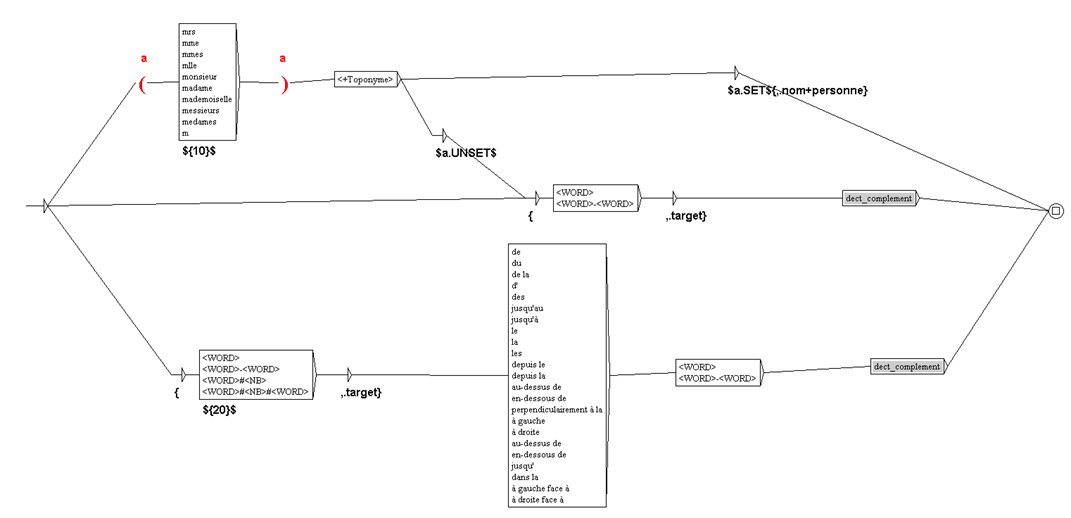

Dans ce graphe, nous utilisons le sous-graphe dect_complement afin de prendre en compte les toponymes de notre dictionnaire avec leurs compléments, de même pour les chemins.
Grâce à des poids, nous regardons d’abord si notre target peut se trouver avant notre toponyme séparé par des prépositions. Sinon nous prenons le token juste avant le toponyme et ses compléments. Et nous ne prenons pas en compte les toponymes correspondant à des noms de personnes.


En sortie de ce graphe nous aurons notre texte avec toutes nos targets annotées.

Dans la cascades nous utilisons la sortie de ce graphe avec le graphe appeler_lex_test.

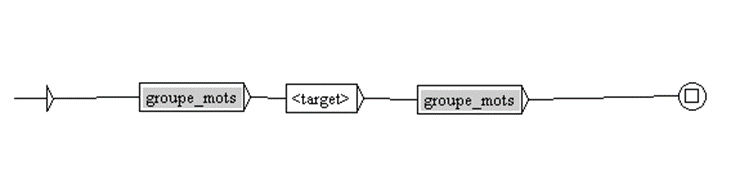

Ce graphe permet de reconnaître les tokens avec l’annotation “target”. Et de selectionner un groupe de mot avant et après notre target. Pour cela nous utilisons le sous-graphe groupe_mots : 

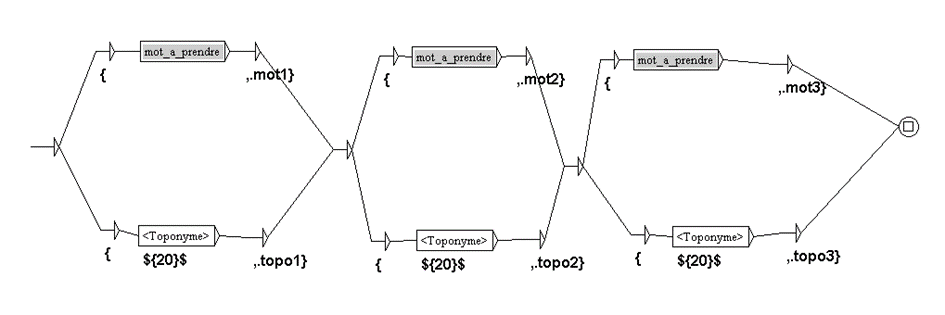

Ce sous-graphe sélectionne trois tokens à la suite, et vérifie d’abord si le token est un toponyme. Le token sera annoté “topo” si c’est un toponyme, et “mot” sinon.
On peut remarquer que nous n’utilisons pas seulement un bloque avec “WORD” pour selectionner les mots. En effet nous utilisons le sous-graphe mot_a_prendre : 

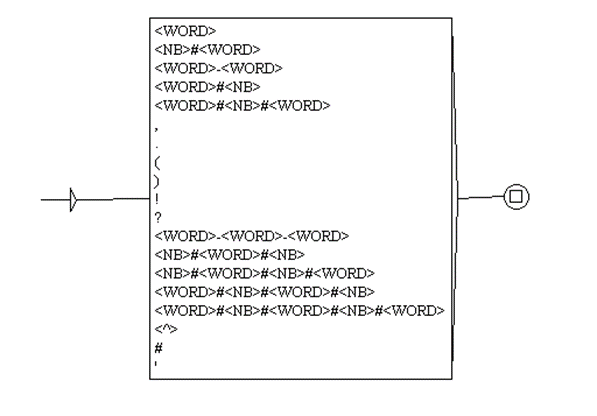

Ce sous-graphe nous permet de gérer les exceptions rencontrées lors de la création de nos graphes. Il prendra par exemple en compte, les tokens “D41A” ou “D238”.

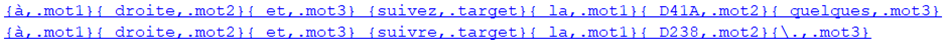

## Résultats de sorties : exemples positifs et négatifs

Une fois qu'on a en sortie nos targets entourées, nous récupérons sur le fichier csc la modification de texte qui s'est faite (). En effet, nous avons un grand fichier texte qui s'est créer annoté comme cela : 

[...] Évitez la bifurcation et continuer tout droit jusqu'à une piste carrossable dans une plantation de jeunes <csc><form>pins</form><code>mot1</code></csc><csc><form>.</form><code>mot2</code></csc><csc><form> La</form><code>mot3</code></csc> <csc><form>suivre</form><code>target</code></csc><csc><form> jusqu</form><code>mot1</code></csc><csc><form>'</form><code>mot2</code></csc><csc><form>à</form><code>mot3</code></csc> [...]

Ici, nous avons un exemple de la base positif car tous les mots qui entourent notre "target" sont des mots. 


[...] Continuer en direction <csc><form>des</form><code>mot1</code></csc><csc><form> gorges</form><code>mot2</code></csc><csc><form> en</form><code>mot3</code></csc> <csc><form>longeant</form><code>target</code></csc><csc><form> le</form><code>mot1</code></csc><csc><form> .</form><code>mot2</code></csc><csc><form>Verdus</form><code>topo3</code></csc>. [...]

Ici, nous avons un exemple de la base négatif car un des mots qui entoure notre "target" est un toponyme.

Maintenant, nous allons chercher à prendre la sortie faite avec unitex pour créer deux groupes de liste de mot : 
- Positif : encadré que par "mot"
- Negatif : dès que nous voyons qu'un des mots est encadré par "topo"

D'abord on a cherché à extraire tous les mots encadrés par "form" ainsi que le code les représentants. 
    
Pour cela, nous avons utilisé la librarie bs4. En effet, la classe bs4.BeautifulSoup permet de créer un objet Python représentant un document HTML. De ce fait, on peut analyser notre texte qui est sous forme html. 
    
Cependant, nous avons du créer une exception dans le code car il peut arriver que des mots soit des targets ainsi que des mot1 ou topo1 (ou 2 ou 3). Pour cela, on a rajouté la condition if word[-6:] == "target" afin de bien prendre que le mot (on supprime les 6 derniers charactères si ça rentre dans cette condition).

In [5]:
def extraction_mots_topo_target():
    dir_path = './CSC/'

    # parcourir tout le fichier
    # il n'y a qu'un fichier au final mais cela revient au meme
    for file_name in os.listdir(dir_path):
        # lire le texte
        with open(os.path.join(dir_path, file_name), 'r', encoding="utf-8") as file:
            text = file.read()

    # créer une instance de l'objet BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')

    # initialiser un dictionnaire pour stocker les correspondances entre les codes et les mots
    codes_to_words = []

    # extraire les mots encadrés par <form>
    for form in soup.find_all('form'):
        code = form.find_next_sibling('code').text
        word = form.text
        if word[-6:] == "target":
            word = word[:-6]

        codes_to_words.append([code, word])

    return codes_to_words

codes_and_words = extraction_mots_topo_target()

In [37]:
codes_and_words[:7]

[['mot3', 'à'],
 ['target', 'partir'],
 ['mot1', ' de'],
 ['mot2', ' .'],
 ['topo3', 'Saint Albin'],
 ['target', 'chapelle'],
 ['target', 'km']]

Puis, nous créons une liste qui prend en son centre le mot "target" et ses voisins. Nous avons rajouté le fait de prendre le maximum entre 0 et l'emplacement du mot autour de target afin de régler le problème lorsque le target est en première position. De même lorsqu'on ait à la fin de notre texte, on prend le minimum. 

In [7]:
resul = []
n  = len(codes_and_words)
for i, pair in enumerate(codes_and_words):
    if pair[0] == 'target':
        resul.append([codes_and_words[max(0, i-3):i] + codes_and_words[i] + codes_and_words[i+1:min(i+4, n)]])

Puis, nous séparons en deux notre liste. Nous ajoutons dans la liste négatif les listes de mot qui contiennent un toponyme et dans la liste positif nous ajoutons le reste. 

In [8]:
negatif = []
positif = []

for i, pair in enumerate(resul):
    find = True
    for k, test in enumerate(pair[0]):
        if test[0] == 'topo1' or test[0] == 'topo2' or test[0] == 'topo3':
            negatif.append(pair)
            find = False
            break
    if find: 
        positif.append(pair)

Grâce à cela, nous créons deux dataframes. 

Si le mot target est bien entouré par 3 mots autour de lui, on ajoute simplement dans une liste les mots que l'on ajoute à notre dataframe. 

Si cela n'est pas le cas, nous regardons l'emplacement de target et ainsi, nous rajoutons un mot vide ("") lorsque nous n'avons aucun mot. 

In [9]:
def split_csv(listes):
    df = pd.DataFrame(columns=['col1', 'col2', 'col3', 'target', 'col4', 'col5', 'col6'])

    # Initialisation de la liste de sous-listes
    sublists = []

    # Parcours de chaque élément de la liste initiale
    for sublist in listes:
        list_neg = []
        emplacement_k = 0
        
        # quand on a tout : bien encadré
        if len(sublist[0]) == 8:
            for k in sublist[0]:
                if isinstance(k, list):
                    list_neg.append(k[1])
                elif k != 'target':
                    list_neg.append(k)

        # sinon
        else:
            emplacement_target = sublist[0].index('target')
            if (emplacement_target < 3):
                for rajout in range(emplacement_target,3):
                    list_neg.append("")

                for k in sublist[0]:
                    if isinstance(k, list):
                        list_neg.append(k[1])
                    elif k != 'target':
                        list_neg.append(k)

            else:
                for k in sublist[0]:
                    if isinstance(k, list):
                        list_neg.append(k[1])
                    elif k != 'target':
                        list_neg.append(k)
                for rajout in range(emplacement_target+1, 7):
                    list_neg.append("")

        df2 = pd.DataFrame([list_neg], columns=['col1', 'col2', 'col3', 'target', 'col4', 'col5', 'col6'])
        df = pd.concat([df, df2], axis=0)

    return df

Voici la sortie de cette fonction : 

In [10]:
df_neg = split_csv(negatif)
df_neg

,col1,col2,col3,target,col4,col5,col6
0,,,à,partir,de,.,Saint Albin
0,de,.,Saint Albin,chapelle,km,de,.
0,.,Saint Albin,chapelle,km,de,.,Quimper
0,de,.,Quimper,vers,Après,la,visite
0,la,petite,route,près,de,.,Kéradily
...,...,...,...,...,...,...,...
0,avec,belles,vues,sur,le Mont,.,Dore
0,le Mont,.,Dore,et,l,',autre
0,l,',autre,côté,du,Puy,de
0,',arriver,à,super,.,Besse,)


In [11]:
df_pos = split_csv(positif)
df_pos

,col1,col2,col3,target,col4,col5,col6
0,Après,la,visite,extérieure,de,la,chapelle
0,la,chapelle,",",suivre,le,chemin,qui
0,.,Poursuivre,",",traverser,le,ruisseau,de
0,laissant,sur,la,droite,le,moulin,de
0,à,l,',entrée,du,hameau,de
...,...,...,...,...,...,...,...
0,en,face,.,Suivre,les,crêtes,jusqu
0,.,Au,col,prendre,le,chemin,à
0,est,assez,dangereuse,dans,un,chemin,de
0,de,VTT,.,Suivre,le,chemin,jusqu


Nous remarquons que le dataset négatif est plus grand que le positif. De ce fait, on supprime les dernières lignes du dataset négatif. 

In [12]:
n_pos = len(df_pos)
df_negativ = df_neg.iloc[:n_pos]
df_negativ

,col1,col2,col3,target,col4,col5,col6
0,,,à,partir,de,.,Saint Albin
0,de,.,Saint Albin,chapelle,km,de,.
0,.,Saint Albin,chapelle,km,de,.,Quimper
0,de,.,Quimper,vers,Après,la,visite
0,la,petite,route,près,de,.,Kéradily
...,...,...,...,...,...,...,...
0,.,Romarinier,puis,contourner,le,ravin,de
0,Roubinastre,en,empruntant,un,.,grand,chemin
0,On,arrive,au,village,de,.,Rimplas
0,route,et,pénètre,dans,le,.,Valdeblore


Puis, voilà la sortie pour les mettres en csv : 

In [13]:
df_pos.to_csv('positif.csv', index=False, encoding="utf-8-sig")

In [14]:
df_negativ.to_csv('negatif.csv', index=False, encoding="utf-8-sig")

En sortie, nous avons deux fichiers csv qui prennent mal les séparations par des virgules, on a donc fait une conversion pour bien séparer en 7 (3 mots avant, target et 3 mots après) nos exemples. Puis, on ajoute le label (1 pour V et 0 pour F) en fonction du fichier csv. Ainsi, on concaténe les deux ensembles pour n'avoir qu'un seul jeu de données. De plus, nous avons rajouté une colonne (la dernière) où on a concaténer tous les mots afin de faire les phrases. Cela nous permet d'avoir un jeu de données assez large en fonction de comment nous souhaitons traiter le reste du projet.

Nous obtenons : 

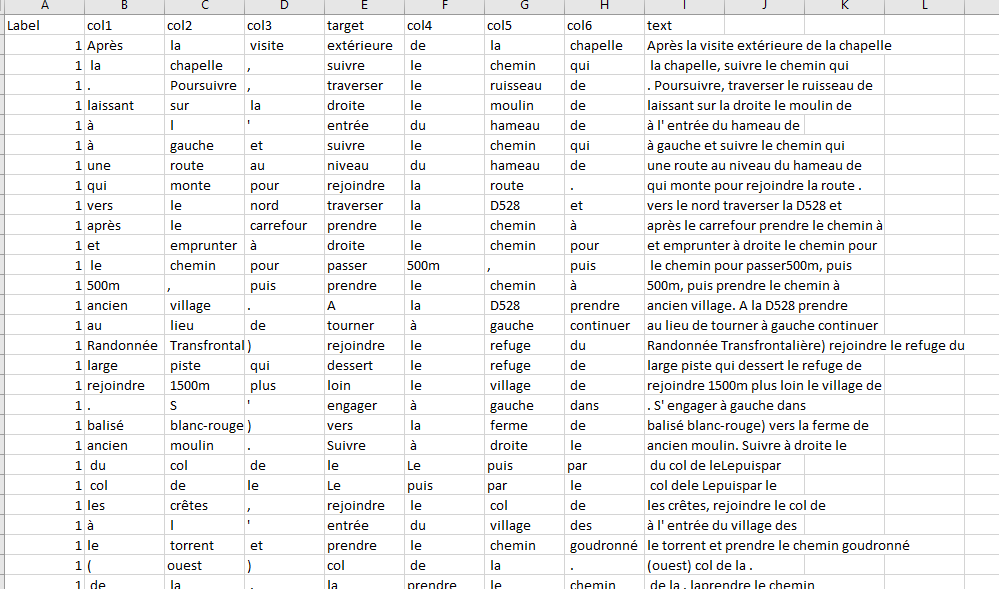
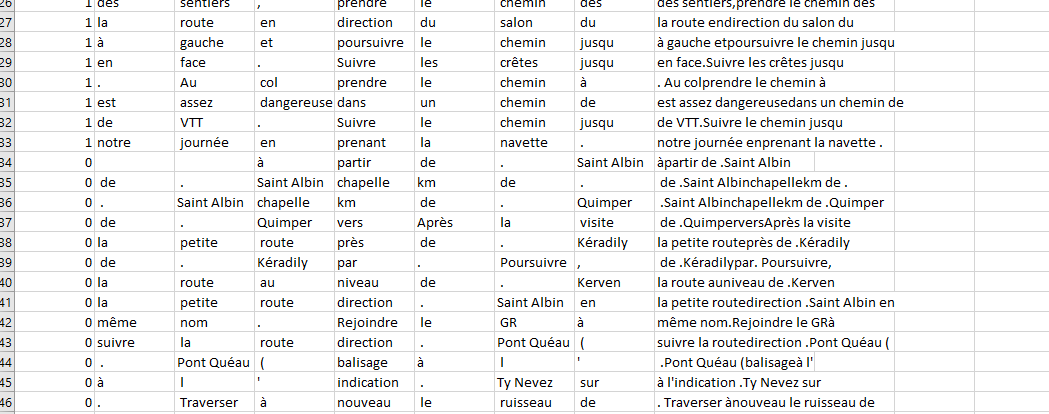

Maintenant, nous pouvons passer à la partie 2. 

# Partie 2 : Apprentissage supervisé

In [15]:
data = pd.read_csv("bdd.csv", sep=";", encoding='utf-8-sig')
data

,Label,col1,col2,col3,target,col4,col5,col6,text
0,1,Après,la,visite,extérieure,de,la,chapelle,Après la visite extérieure de la chapelle
1,1,la,chapelle,",",suivre,le,chemin,qui,"la chapelle, suivre le chemin qui"
2,1,.,Poursuivre,",",traverser,le,ruisseau,de,". Poursuivre, traverser le ruisseau de"
3,1,laissant,sur,la,droite,le,moulin,de,laissant sur la droite le moulin de
4,1,à,l,',entrée,du,hameau,de,à l' entrée du hameau de
...,...,...,...,...,...,...,...,...,...
1459,0,.,Romarinier,puis,contourner,le,ravin,de,.Romarinier puis contourner le ravin de
1460,0,Roubinastre,en,empruntant,un,.,grand,chemin,Roubinastre en empruntant un .grand chemin
1461,0,On,arrive,au,village,de,.,Rimplas,On arrive au village de .Rimplas
1462,0,route,et,pénètre,dans,le,.,Valdeblore,route et pénètre dans le .Valdeblore


Tout d'abord, on a préparé les données. En effet, on utilise le jeu de données étiquetés créé plus tôt. 

In [16]:
# Prepare your data
text_data = data.iloc[:,-1]
    
# Create labeled dataset
labels = data.iloc[:,0]

Ensuite, on divise vos données en ensembles d'entraînement et de test.

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.2, stratify = labels)

Ensuite, on transforme nos données texte en vecteurs numériques en utilisant le vecteur TfidfVectorizer, qui calcule le poids TF-IDF des mots dans chaque texte. En effet, TfidfVectorizer est une classe dans la bibliothèque Python scikit-learn qui permet de convertir une collection de documents textuels en une matrice de vecteurs de fréquence-inverse de document (TF-IDF). La mesure TF-IDF accorde une valeur plus élevée aux termes qui apparaissent fréquemment dans un document particulier, mais qui sont rares dans l'ensemble de la collection de documents.

In [18]:
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(X_train)
test_vectors = tfidf_vectorizer.transform(X_test)

## Regression logistique 

Pour commencer, on a voulu tester en faisant simplement une régression logistique qui appartient à la famille des modèles d'apprentissage automatique supervisé. C'est un modèle discriminatif, c'est-à-dire qu'il va chercher à distinguer les classes (1 et 0 ici). Ces avantages sont : 

- Facile à interpréter: La régression logistique fournit des coefficients pour chaque variable d'entrée, ce qui facilite l'interprétation de la relation entre les variables et la sortie.

- Bonne performance sur de petites quantités de données: la régression logistique peut fonctionner bien même lorsque le nombre de données est relativement faible.

- Aucune hypothèse de normalité requise: Contrairement à certains algorithmes de classification, la régression logistique ne nécessite pas que les données d'entrée soient normalement distribuées.

- Peut gérer des entrées catégorielles: la régression logistique peut facilement gérer des entrées catégorielles telles que des mots-clés ou des catégories de produits.

En résumé, la régression logistique est souvent un choix judicieux pour la classification binaire en raison de sa facilité d'interprétation, de sa bonne performance sur des ensembles de données relativement petits et de sa capacité à gérer des entrées catégorielles.

In [19]:
# Train your model using logistic regression
model = LogisticRegression()
model.fit(train_vectors, y_train)

LogisticRegression()

In [20]:
# Test your model
y_pred = model.predict(test_vectors)

Ensuite, on utilise différentes métriques d'évaluation telles que la précision, le rappel, le score F1 et l'exactitude pour évaluer les performances de notre modèle.

- Accuracy : la proportion de prédictions correctes du modèle sur l'ensemble des prédictions. Elle mesure la capacité d'un modèle à classifier correctement toutes les classes.

- Précision : mesure la proportion de vrais positifs (VP) parmi tous les exemples que le modèle a classé comme positifs. Elle est souvent utilisée lorsque la classe positive est rare. Elle mesure la capacité d'un modèle à ne pas classer de faux positifs.

- Recall : mesure la proportion de vrais positifs (VP) parmi tous les exemples qui sont réellement positifs. Il est souvent utilisé lorsque la classe positive est importante. Il mesure la capacité d'un modèle à ne pas manquer de vrais positifs (éviter les faux négatifs).

- F1-score : une moyenne harmonique de la précision et du rappel, et est une mesure de la performance globale d'un modèle. Il donne une importance égale à la précision et au rappel. Il est souvent utilisé lorsque les classes sont équilibrées.

In [21]:
# Evaluate model performance using different metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))


Accuracy: 0.73
Precision: 0.69
Recall: 0.82
F1 score: 0.75


In [22]:
confusion_matrix(y_test, y_pred)

array([[ 93,  53],
       [ 27, 120]], dtype=int64)

On remarque que ce modèle n'est pas le plus optimal. 

## SVM

On a donc voulu essayer avec un modèle SVM pour la classification binaire. Ces avantages sont : 
- Performances élevées : Les SVM sont connus pour leur capacité à bien fonctionner sur des ensembles de données à grande échelle et à haute dimensionnalité, tels que des ensembles de données de texte. Ils peuvent être particulièrement efficaces dans des situations où les données ne sont pas linéairement séparables.

- Robustesse aux données bruyantes : Les SVM ont une bonne capacité à gérer les données bruyantes, ce qui peut être utile dans le cas de données textuelles où il peut y avoir des fautes de frappe, des fautes d'orthographe ou des variations de cas.

- Capacité à gérer les données textuelles : Les SVM peuvent facilement gérer les données textuelles, car ils peuvent être utilisés avec différents types de fonction de noyau, tels que les noyaux linéaires et les noyaux basés sur des fonctions de similarité de texte.

- Bonne généralisation : Les SVM ont une bonne capacité à généraliser à de nouvelles données, ce qui peut être utile dans des situations où les données d'entraînement et de test sont différentes.

- Interprétabilité : Les SVM sont souvent considérés comme plus interprétables que certains autres algorithmes de classification, tels que les réseaux de neurones.

On entraîne notre modèle SVM en utilisant les vecteurs d'entraînement et les étiquettes associées, puis prédire les étiquettes des vecteurs de test:

In [23]:
svm = SVC(kernel='linear')
svm.fit(train_vectors, y_train)
predictions = svm.predict(test_vectors)

In [24]:
confusion_matrix(y_test, predictions)

array([[ 93,  53],
       [ 18, 129]], dtype=int64)

In [25]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.64      0.72       146
           1       0.71      0.88      0.78       147

    accuracy                           0.76       293
   macro avg       0.77      0.76      0.75       293
weighted avg       0.77      0.76      0.75       293



In [26]:
# Evaluate model performance using different metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))

Accuracy: 0.76
Precision: 0.71
Recall: 0.88
F1 score: 0.78


Ce tableau de classification nous permet de comprendre les performances de notre modèle de classification binaire en termes de précision, de rappel et de F1-score pour chaque classe, ainsi que pour l'ensemble des classes. Cela peut nous aider à identifier les points faibles de notre modèle et à l'améliorer en conséquence. Il est nous permet d'évaluer la qualité de la prédiction de classes (1 (Vrai)/0 (Faux) ici) d'un modèle par rapport aux classes réelles.

Ce modèle est légérement meilleur. Nous voyons notamment une amélioration au niveau de la précision des vrais faux. 

## Naïve Bayes

On a donc voulu essayer avec un modèle naïve bayes pour la classification de texte. Ces avantages sont : 

- Rapide et facile à implémenter : Le modèle Naive Bayes est rapide à entraîner et à prédire, car il ne nécessite pas de grandes quantités de données pour obtenir des résultats précis. Il peut également gérer des milliers de fonctionnalités sans problème.

- Fonctionne bien avec des données de grande dimension : Le modèle Naive Bayes fonctionne bien avec des données de grande dimension telles que des matrices de fréquence de termes ou des vecteurs de TF-IDF.

- Robuste aux données manquantes : Le modèle Naive Bayes peut gérer des données manquantes et des valeurs aberrantes car il calcule des probabilités conditionnelles pour chaque classe en ignorant les valeurs manquantes.

- Peut être utilisé pour des tâches de classification multi-classes : Le modèle Naive Bayes peut être utilisé pour la classification binaire, mais aussi pour la classification multi-classes.

- Peut fournir une estimation de la probabilité de classe : Le modèle Naive Bayes peut fournir une estimation de la probabilité de classe pour chaque classe, ce qui peut être utile pour la prise de décision.

Malheureusement, il est limité concernant l'hypothèse de l'indépendance des caractéristiques, qui peut ne pas être vraie dans certains cas. 

On entraîne notre modèle Naïve Bayes en utilisant les vecteurs d'entraînement et les étiquettes associées, puis prédire les étiquettes des vecteurs de test:

In [27]:
nb = MultinomialNB()
nb.fit(train_vectors, y_train)
predictions = nb.predict(test_vectors)

Ainsi, on peut évaluer les performances de votre modèle en comparant les étiquettes prédites avec les étiquettes réelles des données de test:

In [28]:
confusion_matrix(y_test, predictions)

array([[ 75,  71],
       [ 11, 136]], dtype=int64)

In [29]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.51      0.65       146
           1       0.66      0.93      0.77       147

    accuracy                           0.72       293
   macro avg       0.76      0.72      0.71       293
weighted avg       0.76      0.72      0.71       293



In [30]:
# Evaluate model performance using different metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1))

Accuracy: 0.72
Precision: 0.66
Recall: 0.93
F1 score: 0.77


Ce modèle n'est pas le meilleur. En effet, on ne voit aucune amélioration dans la justesse de nos prédictions.  

# Conclusion 

Pour commencer, nous avons travailler en binome pour la création du dictionnaire car nous avons voulu bien comprendre le sujet et la demande avant de séparer les tâches de travaille. Ensuite, Thomas s'est concentré sur la création des graphiques sous l'Unitex et Rebecca a l'écriture d'un code python pour créer un apprentissage supervisé. Cependant, nous partageons régulièrement nos sorties et nos problèmes. Nous nous sommes beaucoup conseillés et entre-aidés. 

Concernant l'avancement du projet, nous avons trouvé un moyen de faire un dictionnaire le plus complet possible. Malheureusement les toponymes qui ne sont pas dans le dictionnaire fourni ainsi que celui fourni par Geonames et qui n'ont pas de majuscule n'ont malheureusement pas été trouvé. On le remarque avec le texte 16 qui inclut : "La neuville". 

Puis, nous avons voulu faire une cascade le plus complet comprenant tout types d'exceptions que nous avons pu voir. Mais malheuresement nous avons remarqué que les phrases tel que : "le carrefour du chemin qui remonte vers le col de Sarenne," où nous ne prenons que le mot "chemin" en tant qu'expression nominales au lieu de "carrefour du chemin". Mais nos graphiques fonctionnent pour des expressions tel que : "la caillasse jusqu'au Lac des Quirlies".

Enfin, concernant la création de modèle, nous avons voulu en essayer plusieurs afin de les comparer. Cependant, nous n'avons jamais obtenu un pourcentage de bonne prédiction correct (rien de superieur à 90%). Le modèle de SVM est le meilleur même si il ne reste pas très optimal. 